In [2]:
# Import Transformer Lens, and load pythia models
from transformer_lens import HookedTransformer
import torch as th
from torch import nn
import numpy as np 
from neuron_text_simplifier import NeuronTextSimplifier
from datasets import Dataset, load_dataset
from transformers import AutoTokenizer
from torch.utils.data import DataLoader
from tqdm import tqdm
from einops import rearrange
device = th.device("cuda" if th.cuda.is_available() else "cpu")

# model_name = "EleutherAI/pythia-160m-deduped"
model_name = "solu-1l"
model = HookedTransformer.from_pretrained(model_name, device=device)

tokenizer = AutoTokenizer.from_pretrained(model_name)
Token_amount = 20

# Load the training set from pile-10k
d = load_dataset("NeelNanda/pile-10k", split="train").map(
    lambda x: tokenizer(x['text']),
    batched=True,
).filter(
    lambda x: len(x['input_ids']) > Token_amount
).map(
    lambda x: {'input_ids': x['input_ids'][:Token_amount]}
)

neurons = model.W_in.shape[-1]
datapoints = d.num_rows
batch_size = 64
layer = 0

neuron_activations = th.zeros((datapoints*Token_amount, neurons))
try:
    neuron_activations = th.load(f"Data/{model_name}_activations_layer_{layer}.pt")
    print("Loaded activations from file")
except:
    with th.no_grad(), d.formatted_as("pt"):
        dl = DataLoader(d["input_ids"], batch_size=batch_size)
        for i, batch in enumerate(tqdm(dl)):
            _, cache = model.run_with_cache(batch.to(device))
            neuron_activations[i*batch_size*Token_amount:(i+1)*batch_size*Token_amount,:] = rearrange(cache[f"blocks.{layer}.mlp.hook_pre"], "b s n -> (b s) n" )
    th.save(neuron_activations, f"Data/{model_name}_activations_layer_{layer}.pt")

c:\Users\logan\miniconda3\envs\max\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using pad_token, but it is not set yet.


Loaded pretrained model gpt2 into HookedTransformer


Using custom data configuration NeelNanda--pile-10k-72f566e9f7c464ab
Found cached dataset parquet (C:/Users/logan/.cache/huggingface/datasets/NeelNanda___parquet/NeelNanda--pile-10k-72f566e9f7c464ab/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
Loading cached processed dataset at C:\Users\logan\.cache\huggingface\datasets\NeelNanda___parquet\NeelNanda--pile-10k-72f566e9f7c464ab\0.0.0\2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec\cache-82ba2468faaff7f2.arrow
Loading cached processed dataset at C:\Users\logan\.cache\huggingface\datasets\NeelNanda___parquet\NeelNanda--pile-10k-72f566e9f7c464ab\0.0.0\2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec\cache-d4cd439d88a39109.arrow
Loading cached processed dataset at C:\Users\logan\.cache\huggingface\datasets\NeelNanda___parquet\NeelNanda--pile-10k-72f566e9f7c464ab\0.0.0\2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec\cache-2d14fe0389d89b96.arrow


Loaded activations from file


In [3]:
neuron = 0
k = 10
simplifier = NeuronTextSimplifier(model, layer, neuron)
# For neuron, get the top 10 datapoints that activate it the most
values, indices = neuron_activations[:,neuron].topk(k)
max_datapoints = [np.unravel_index(i, (datapoints, Token_amount)) for i in indices]

text_list = []
full_text = []
for md, s_ind in max_datapoints:
    md = int(md)
    s_ind = int(s_ind)
    full_tok = d[md]["input_ids"]
    full_text.append(tokenizer.decode(full_tok))

    tok = d[md]["input_ids"][:s_ind+1]
    text = tokenizer.decode(tok)
    text_list.append(text)
simplifier.text_to_visualize(full_text)

In [4]:
simplifier.visualize_text_color_iteratively(text_list[:2])

In [29]:
# Prompt Invariance Test
# Take the last token of the top-10 datapoints, check if neuron activation is within 1% of the max activation
# when we remove the entire prompt
percent_diff = 0.01
percent_unchanged = th.zeros(len(text_list))
for text_ind in range(len(text_list)):
    text = text_list[text_ind]
    token = simplifier.model.to_tokens(text, prepend_bos=False)
    last_token = th.tensor([token[0,-1]])
    normal_activations = simplifier.get_neuron_activation(token)[-1]
    no_prompt_activations = simplifier.get_neuron_activation(last_token)[-1]
    # Check if within 1% of the max activation
    percent_unchanged[text_ind] = abs((no_prompt_activations - normal_activations) / normal_activations) < percent_diff
print(f"Prompt Invariance Test: {percent_unchanged.mean()}/1.0")

Prompt Invariance Test: 1.0/1.0


In [11]:
token

tensor([[ 6104,   857,  1190, 44483]])

In [190]:
simplifier.prompt_optimization(seq_size=1)

Starting diverse output 0
New largest activation: 2.1048388481140137 | [' Brownian']
New largest activation: 2.1420769691467285 | [' pend']
Starting diverse output 1
New largest activation: 2.1048388481140137 | [' Brownian']
New largest activation: 2.1420769691467285 | [' pend']
Starting diverse output 2
New largest activation: 0.6322449445724487 | [' syscall']
New largest activation: 1.8989596366882324 | ['substr']
New largest activation: 2.1048388481140137 | [' Brownian']
New largest activation: 2.1420769691467285 | [' pend']
Starting diverse output 3
New largest activation: 0.18056875467300415 | ['\n\n       ']
New largest activation: 2.1048388481140137 | [' Brownian']
New largest activation: 2.1420769691467285 | [' pend']
Starting diverse output 4
New largest activation: 1.8989596366882324 | ['substr']
New largest activation: 2.1048388481140137 | [' Brownian']
New largest activation: 2.1420769691467285 | [' pend']
Starting diverse output 5
New largest activation: 1.8989596366882324

KeyboardInterrupt: 

In [119]:
oam_text = '\x16bird5"><'
# 3070
activate_list = [
    '><"meta"><',
    '"meta"><',
    '5"meta"><',
    '><"bird"><',
    '><bird"><',
    '><"bird><',
    ]
# 3069
falsify_list = [
    "here today",
    "Michael p.m",
    "Washington p.m",
    "Mississippi p.m",
    " kadisty čстав",
    " čставčставčстав",
    # "Monday \"><40020 p.m",
    # "Monday \"><60 p.m",
    # "Monday \"><Twenty p.m",
    # "Monday :00 p.m",
    # "Monday 5:47 p.m",
    # "Monday 5:100 p.m",
    # "Monday 500:100 p.m",
    # "Monday 69:420 p.m",
]
# 3068
rand_tok = th.randint(0, simplifier.model.W_E.shape[0], (1, 1))

falsify_list = [
    # " we cluster below below below below",
    # " we cluster 1 2 3 4 5 6 7 below",
    # " we cluster 1 2 3 4 5 6 below",
    # " we cluster 1 2 3 4 5 below",
    # " we cluster 1 2 3 4 below",
    # " we cluster 1 2 3 below",
    # " we cluster 1 2 below",
    # " we cluster 1 below",
    # " most except cold",
    # "spots except cold",
    # "spots 1 except cold",
    # "spots 1 2 except cold",
    # "spots 1 2 3 except cold",
    # " 1 2 3 except cold",
    # "spots except 1 cold",
    # "spots except 1 2 cold",
    # " except 1 2 3 cold",
    # "<|endoftext|> dominates excited",
    # "<|endoftext|> dominates 1 excited",
    # "<|endoftext|> dominates 1 2 excited",
    # "<|endoftext|> dominates 1 2 3 excited",
    # " minimum excluding occurring 1 2 3 warm",
    # " minimum excluding occurring 1 2 warm",
    # " minimum excluding occurring 1 warm",
    # " minimum excluding occurring warm",
    # "  methylation dominates episodes excited",
    # "  1 methylation dominates episodes excited",
    # "  1 2 methylation dominates episodes excited",
    # "  1 2 3 methylation dominates episodes excited",
    # "  methylation 1 dominates episodes excited",
    # "  methylation 1 2 dominates episodes excited",
    # "  methylation 1 2 3 dominates episodes excited",
    # "  methylation dominates 1 episodes excited",
    # "  methylation dominates 1 2 episodes excited",
    # "  methylation dominates 1 2 3 episodes excited",
    # "  methylation dominates episodes 1 excited",
    # "  methylation dominates episodes 1 2 excited",
    # "  methylation dominates episodes 1 2 3 excited",
    " To during" +simplifier.model.to_string(rand_tok)[0]+" hours",
    # " To during the hours",
    # " To during 1 hours",
    # " To during 1 2 hours",
    # " To during 1 2 3 hours",
    # " To during : hours",
    # " To during ! hours",
    # " To during j hours",
    # " To during   hours",
    # "<|endoftext|> excluding 1 2 3 warm",
    # "<|endoftext|> excluding 1 2 warm",
    # "<|endoftext|> excluding 1 warm",
    # "<|endoftext|> excluding warm",
    # " catchesocene incl",
    # " catchesocene 1 incl",
    # " catchesocene 1 2 incl",
    # " catchesocene 1 2 3 incl",
    # " catchesocene 1 2 3 4 incl",
    # " inclinable",
    # " inclemency",
    # " inclasping",
    # " inclasped",
    # " inclosures",
    # " minima surrounded below III",
    # " minima surrounded below warm",
]

def buffer_invariance_statistics(text):
    # if text is str then convert to list
    # if isinstance(text, str):
    #     text = [text]
    # Convert into a tokenized list
    tokens = simplifier.model.to_tokens(text)
    # for each slot in the tokens, we add N buffer tokens, saving the mean and std of the output
    token_len = tokens.shape[-1]
    N = 10
    max_buffer_tokens = 4
    for tok_ind in range(token_len):
        for buffer_tokens in range(1, max_buffer_tokens+1):
            stats = th.zeros((N))
            for n in range(N):
                # generate a random token
                rand_tok = th.randint(0, simplifier.model.W_E.shape[0], (1, buffer_tokens))
                # add the token to the list of tokens
                token_and_buffer = th.cat([tokens[:, :tok_ind], rand_tok, tokens[:, tok_ind:]], dim=1)
                # Run through the model to get the activation
                stats[n] = simplifier.get_neuron_activation(token_and_buffer)[-1] # Get the last activation
            print(f"Index: {tok_ind}, #buffers: {buffer_tokens} Mean: {stats.mean()}, Std: {stats.std()}")
    return

buffer_invariance_statistics(" To during hours")

# TODO add support for multiple inputs
# Combine single & multi-text
# simplifier.visualize_text_color_iteratively(oam_text)
# simplifier.text_to_visualize(oam_text)
# simplifier.visualize_text_color_iteratively(text_list)

# simplifier.text_to_visualize(falsify_list)

# TODO add code for testing for invariance to buffer tokens in different positions, defined as an 80% drop in performance, or just generally give the statistics for each one.
# could be applied to the final values found in the prompt optimization.

Index: 0, #buffers: 1 Mean: 2.042489767074585, Std: 0.07547583431005478
Index: 0, #buffers: 2 Mean: 2.0138843059539795, Std: 0.1060929223895073
Index: 0, #buffers: 3 Mean: 1.9910056591033936, Std: 0.09361206740140915
Index: 0, #buffers: 4 Mean: 1.961168885231018, Std: 0.08485544472932816
Index: 1, #buffers: 1 Mean: 1.9625946283340454, Std: 0.09443136304616928
Index: 1, #buffers: 2 Mean: 1.8755232095718384, Std: 0.09720455855131149
Index: 1, #buffers: 3 Mean: 1.9654653072357178, Std: 0.11171015352010727
Index: 1, #buffers: 4 Mean: 1.8568780422210693, Std: 0.08919225633144379
Index: 2, #buffers: 1 Mean: 1.8630273342132568, Std: 0.08168153464794159
Index: 2, #buffers: 2 Mean: 1.8677890300750732, Std: 0.1256934553384781
Index: 2, #buffers: 3 Mean: 1.7821543216705322, Std: 0.17293889820575714
Index: 2, #buffers: 4 Mean: 1.8511985540390015, Std: 0.1639268398284912
Index: 3, #buffers: 1 Mean: 1.532529354095459, Std: 0.18904978036880493
Index: 3, #buffers: 2 Mean: 1.3125635385513306, Std: 0.31

In [153]:
from tqdm import tqdm
text = " To during hours"
tokens = simplifier.model.to_tokens(text)
model_vocab = simplifier.model.W_E.shape[0]
stats = th.zeros((model_vocab))
token_and_buffer = th.cat([tokens[:, :-1], tokens[:,0:1], tokens[:, -1:]], dim=1)
for tok_ind in tqdm(range(model_vocab)):
    token_and_buffer[:,-2] =  tok_ind
    stats[tok_ind] = simplifier.get_neuron_activation(token_and_buffer)[-1] # Get the last activation

# add the token to the list of tokens
# Run through the model to get the activation

100%|██████████| 50304/50304 [1:26:42<00:00,  9.67it/s]


In [140]:
tok_ind

0

In [154]:
# print the mean, median, std, min, and max of the stats
print(f"Mean: {stats.mean()}, Median: {stats.median()}, Std: {stats.std()}, Min: {stats.min()}, Max: {stats.max()}")

Mean: 1.521121859550476, Median: 1.5260882377624512, Std: 0.23193170130252838, Min: 0.4696179926395416, Max: 2.387392282485962


(array([1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 4.000e+00, 1.000e+00,
        3.000e+00, 0.000e+00, 3.000e+00, 0.000e+00, 5.000e+00, 6.000e+00,
        5.000e+00, 9.000e+00, 1.200e+01, 1.300e+01, 1.600e+01, 2.000e+01,
        2.800e+01, 3.100e+01, 4.000e+01, 3.300e+01, 5.400e+01, 7.200e+01,
        8.600e+01, 1.060e+02, 1.360e+02, 1.360e+02, 1.660e+02, 2.070e+02,
        2.350e+02, 2.750e+02, 3.070e+02, 3.530e+02, 4.310e+02, 4.560e+02,
        5.100e+02, 5.650e+02, 6.480e+02, 7.130e+02, 7.960e+02, 8.950e+02,
        9.530e+02, 1.010e+03, 1.047e+03, 1.226e+03, 1.231e+03, 1.345e+03,
        1.329e+03, 1.424e+03, 1.489e+03, 1.552e+03, 1.660e+03, 1.732e+03,
        1.647e+03, 1.607e+03, 1.631e+03, 1.622e+03, 1.610e+03, 1.536e+03,
        1.454e+03, 1.438e+03, 1.347e+03, 1.323e+03, 1.263e+03, 1.180e+03,
        1.149e+03, 1.062e+03, 1.018e+03, 8.770e+02, 7.820e+02, 6.830e+02,
        5.920e+02, 5.630e+02, 4.850e+02, 4.020e+02, 3.350e+02, 2.620e+02,
        2.260e+02, 1.850e+02, 1.340e+0

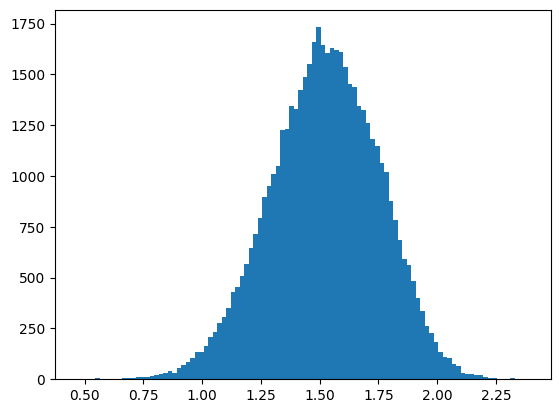

In [156]:
import matplotlib.pyplot as plt
# plot as a histogram
plt.hist(stats[::], bins = 100)

In [170]:
simplifier.model.to_str_tokens(stats.argsort(dim=0, descending=False)[:10])

['arning',
 'newcommand',
 'gets',
 '![](',
 'choose',
 ' wage',
 ').](',
 'mapsto',
 '.](',
 'getting']

In [184]:
# simplifier.model.to_str_tokens("hey there")
simplifier.model.to_tokens("hey there")
simplifier.model.tokenizer("hey there")

{'input_ids': [26512, 627], 'attention_mask': [1, 1]}

In [180]:
tt = th.tensor([[]])
simplifier.model.generate()

100%|██████████| 10/10 [00:00<00:00, 15.09it/s]


' I learn Ronuka (bed) tried Onn'

In [168]:
stats.argsort(dim=0, descending=False)[:10]

tensor([ 4026, 38618, 18145, 12520, 27271, 16610, 17981, 15869,  5774, 35777])

In [101]:
rand_tok = th.randint(0, simplifier.model.W_E.shape[0], (1, 1))
rand_tok

tensor([[26781]])

In [70]:
tokens = simplifier.model.to_tokens(text)
tokens.shape

torch.Size([1, 5])

In [46]:
text = [
    " minimum excluding occurring warm", 
]
simplifier.visualize_text_color_iteratively(text)

In [20]:
tokens = simplifier.model.to_tokens(text, prepend_bos=False)[0]
original_activation = simplifier.get_neuron_activation(tokens)
# To get around the newline issue, we replace the newline with \newline and then add a newline at the end
text_list = [x.replace('\n', '\\newline') for x in simplifier.model.to_str_tokens(text, prepend_bos=False)] + ["\n"]
act_list = original_activation + [0.0]
changes = th.zeros(tokens.shape[-1])+100
for j in range(len(tokens)-1):
    for i in range(len(tokens)):
        changes[i] = simplifier.get_neuron_activation(th.cat((tokens[:i],tokens[i+1:])))[-1]
    max_ind = changes.argmax()
    changes = th.cat((changes[:max_ind], changes[max_ind+1:]))
    tokens = th.cat((tokens[:max_ind],tokens[max_ind+1:]))
    if(tokens.shape[-1] > 1):
        out_text = simplifier.model.to_str_tokens(tokens, prepend_bos=False)
        text_list += [x.replace('\n', '\\newline') for x in out_text] + ["\n"]
    else:
        out_text = simplifier.model.to_string(tokens)
        text_list += [out_text.replace('\n', '\\newline')] + ["\n"]
    act_list += simplifier.get_neuron_activation(tokens) + [0.0]
text_list = text_list
act_list = th.tensor(act_list).reshape(-1,1,1)
from circuitsvis.activations import text_neuron_activations
text_neuron_activations(tokens=text_list, activations=act_list)

In [19]:
out_text

']):'

In [15]:
from circuitsvis.activations import text_neuron_activations
text_neuron_activations(tokens=text_list, activations=act_list)

In [17]:
simplifier.model.to_string(tokens)

']):'

In [7]:
tokens.shape[0] == 1

True

In [1]:
layer = 6
neuron = 3070
k = 10
simplifier = NeuronTextSimplifier(model, layer, neuron)
# For neuron, get the top 10 datapoints that activate it the most
values, indices = neuron_activations[:,neuron].topk(k)
max_datapoints = [np.unravel_index(i, (datapoints, Token_amount)) for i in indices]

for md, s_ind in max_datapoints:
    md = int(md)
    s_ind = int(s_ind)
    tok = d[md]["input_ids"]
    # Print out the original text plus saying which word is MAXED!
    original_text_plus_maxxed = model.to_str_tokens(th.tensor(tok))
    original_text_plus_maxxed.insert(s_ind+1, "[[<--MAXED!]]")
    print("".join(original_text_plus_maxxed))
    print("====================================\n===============================")

for md, s_ind in max_datapoints:
    md = int(md)
    s_ind = int(s_ind)
    tok = d[md]["input_ids"]
    # Print out the original text plus saying which word is MAXED!
    text = tokenizer.decode(tok)
    print(text)
    print(simplifier.text_to_activations_print(text))
    tok = d[md]["input_ids"][:s_ind+1]
    text = tokenizer.decode(tok)
    simplifier.simplify_iteratively(text)
    print("====================================\n===============================")

NameError: name 'NeuronTextSimplifier' is not defined

In [240]:
# Python Example
from circuitsvis.tokens import colored_tokens
j = colored_tokens(["My", "tokens", '\n\n\n'], [0.123, -0.226])
print("hey")
j.show_code()

hey


'<div id="circuits-vis-278c9e15-038a" style="margin: 15px 0;"/>\n    <script crossorigin type="module">\n    import { render, ColoredTokens } from "https://unpkg.com/circuitsvis@1.39.1/dist/cdn/esm.js";\n    render(\n      "circuits-vis-278c9e15-038a",\n      ColoredTokens,\n      {"tokens": ["My", "tokens", "\\n\\n\\n"], "values": [0.123, -0.226]}\n    )\n    </script>'

In [227]:
def random_text(N=1):
    return tokenizer.decode(np.random.randint(0, tokenizer.vocab_size, size=N))
text = [
    "ladies and gentlemen",
    " and-and- and",
    " : and-: and", 
]
text = [
    "Salt and Pepper",
    "Salt and Jelly", 
    "Peanut Butter and Jelly",
    "Peanut Butter and Rice", 
    "Red Beans and Rice",
    "Red Beans and Cheese", 
    "Mac and Cheese",
    "Mac and Eggs", 
    "Bacon and Eggs",
    "Bacon and Clyde", 
    "Bonnie and Clyde",
    "Bonnie and Robin", 
    "Batman and Robin",
    "Batman and Minnie", 
    "Mickey and Minnie"
    "Mickey and Pepper"
]
# text = [tokenizer.decode([0]) + t for t in text]
# text = [ # Start with bos token
#     tokenizer.decode([0]) +" and"
# ]
weird_text = [
    " 139",
]
# text = [
#     random_text(1)+" and Mrs. Dalloway" for _ in range(10)
# ]
text = [
    'onds knowsPierre and',
]
print(neuron)
# text = [random_text() + " and" + random_text() for _ in range(20)]
for t in text:
    print(simplifier.text_to_activations_print(t))

3071
onds [0.30] knows [0.26]Pierre [0.95] and [2.80]


In [ ]:
simplifier.simplify_iteratively("About the gained dirt England had")
simplifier.text_to_activations_print("About the gained dirt England had")

In [ ]:
k = 10
values, indices = neuron_activations.topk(k, dim=0)
neuron = 0
print(indices[:,neuron])

In [9]:
from torch.utils.data import DataLoader
from tqdm import tqdm
from einops import rearrange
neurons = model.W_in.shape[-1]
datapoints = d.num_rows
batch_size = 64
layers = len(model.blocks)

for layer in range(layers):
    neuron_activations = th.zeros((datapoints*Token_amount, neurons))
    with th.no_grad(), d.formatted_as("pt"):
        dl = DataLoader(d["input_ids"], batch_size=batch_size)
        for i, batch in enumerate(tqdm(dl)):
            _, cache = model.run_with_cache(batch.to(device))
            neuron_activations[i*batch_size*Token_amount:(i+1)*batch_size*Token_amount,:] = rearrange(cache[f"blocks.{layer}.mlp.hook_pre"], "b s n -> (b s) n" )
    th.save(neuron_activations, f"Data/activations_layer_{layer}.pt")
        

KeyboardInterrupt: 

In [6]:
# Save the activations to a file in Data/

In [216]:
from torch.utils.data import DataLoader
from tqdm import tqdm
from einops import rearrange
neurons = model.W_in.shape[-1]
layers = len(model.blocks)
datapoints = d.num_rows
datapoints = 200
#TODO: make d smaller, like 1000 datapoints
batch_size = 64
smaller_d = d.select(range(datapoints//batch_size*batch_size))
max_loops = 2
max_datapoints = batch_size*max_loops*Token_amount
neuron_activations = th.zeros((max_datapoints, layers, neurons))
inc_amount = batch_size*Token_amount

k = 10
# For data efficiency, we only want to save the top-10 datapoints per neuron,layer pair every max_loops batches
top_10_vals = th.zeros((k, layers*neurons), dtype=th.float)
top_10_ind = th.zeros((k, layers*neurons), dtype=th.int)
new_top_10_vals = th.zeros((k, layers*neurons), dtype=th.float)
new_top_10_ind = th.zeros((k, layers*neurons), dtype=th.int)

with th.no_grad(), smaller_d.formatted_as("pt"):
    dl = DataLoader(smaller_d["input_ids"], batch_size=batch_size)
    for i, batch in enumerate(tqdm(dl)):
        _, cache = model.run_with_cache(batch.to(device))
        for layer in range(layers):
            try:
                neuron_activations[(i % max_loops)*inc_amount:(i % max_loops+1)*inc_amount, layer] = rearrange(cache[f"blocks.{layer}.mlp.hook_pre"], "b s n -> (b s) n" )
            except:
                neuron_activations[(i % max_loops)*inc_amount:, layer] = rearrange(cache[f"blocks.{layer}.mlp.hook_pre"], "b s n -> (b s) n" )
            # finally:
            #     print("what")
            #     break
        # Every max_loops batches, save the top-10 datapoints per neuron,layer pair
        if i % max_loops == 0:
            # Get the top 10 datapoints per neuron,layer pair
            new_top_10_vals, new_top_10_ind = rearrange(neuron_activations, "d l n -> d (l n)").topk(k, dim=0) #TODO is this trash?
            top_10_ind = th.cat((top_10_ind, new_top_10_ind), dim=0) 
            top_10_vals = th.cat((top_10_vals, new_top_10_vals), dim=0)
            top_10_vals, ind = top_10_vals.topk(k, dim=0)
            top_10_ind = top_10_ind.gather(0, ind)
            print(top_10_vals.max())
            # Reset the neuron_activations tensor, or else we may have duplicates
            neuron_activations = th.zeros((max_datapoints, layers, neurons))


import numpy as np 
n = 0
l = 0
# Get the argmax value
largest_ind = top_10_ind[1, n*l].item()
largest_act = top_10_vals[1, n*l]

# Get the text for that index
tokens = d[largest_ind]['input_ids']
l_text = tokenizer.decode(tokens)
print(l_text)
# Get the activations for that index
neuron_simplifier.set_layer_and_neuron(l, n)
print(neuron_simplifier.text_to_activations_print(l_text))
# Verify it's the same as the max value
print(largest_act)

 33%|███▎      | 1/3 [00:02<00:04,  2.42s/it]

tensor(85.7033)


100%|██████████| 3/3 [00:07<00:00,  2.37s/it]

tensor(88.3670)
“ As consciousness is returning to ordinary awareness after intense experiences of a mystical, visionary, or psych
“ [-1.27] As [-2.00] consciousness [-0.31] is [-1.85] returning [-1.86] to [-1.47] ordinary [-0.05] awareness [-0.52] after [-1.61] intense [-0.37] experiences [-0.38] of [-0.42] a [-0.97] mystical [0.10], [-2.01] vision [-0.91]ary [-0.44], [-2.01] or [-1.28] psych [-0.15]
tensor(1.4296)


In [207]:
top_10_ind = th.cat((top_10_ind, new_top_10_ind), dim=0) 
top_10_ind.gather(0, ind)

tensor([[ 636, 1250, 1154,  ...,  612, 1262,  646],
        [ 546,  892,  426,  ...,  389,   46,  653],
        [ 550,  720,  459,  ...,  257,  887,  644],
        ...,
        [ 473, 1115,  407,  ..., 1259,  998,  655],
        [ 323,  919, 1183,  ...,   25,  406,  649],
        [ 512, 1251,  922,  ...,  409,  858,  182]])

In [180]:
th.cat((top_10_ind, top_10_ind), dim=0).gather(1, ind).shape

TypeError: gather() received an invalid combination of arguments - got (Tensor), but expected one of:
 * (int dim, Tensor index, *, bool sparse_grad)
 * (name dim, Tensor index, *, bool sparse_grad)


In [214]:
import numpy as np 
n = 2
l = 0
# get the index
# Get the argmax value
largest_ind = top_10_ind[1, n].item()
largest_act = top_10_vals[1,n]

# Get the text for that index
tokens = d[largest_ind]['input_ids']
l_text = tokenizer.decode(tokens)
# l_text = d[largest_ind]['text'][:100]
print(l_text)

# Get the activations for that index
neuron_simplifier.set_layer_and_neuron(l, n)
print(neuron_simplifier.text_to_activations_print(l_text))
# Verify it's the same as the max value
print(largest_act)

Richtweg (Hamburg U-Bahn station)

Richtweg is a
R [-0.88]icht [0.22]weg [-0.08] ( [-0.42]H [-0.90]amb [-0.60]urg [0.64] U [-0.84]- [-0.31]B [-0.95]ahn [-0.32] station [0.85]) [-0.23]
 [-0.03]
 [-0.03]R [-0.88]icht [0.22]weg [-0.08] is [0.05] a [-0.09]
tensor(1.1365)


In [200]:
top_10_vals[:, 0]

tensor([1.5792, 1.4296, 1.3278, 1.3144, 1.2530, 1.2340, 1.1713, 1.1354, 1.1255,
        1.1074])

In [161]:
d[largest_ind.item()]

{'text': 'Description\n\nShop-Majour offers trendy plus size clothing to fill your closet. Shop trendy plus size clothes in a wide range of styles and designs at affordable price! We have set out to become the source for curvy women that crave trendy high quality fashions at affordable prices. To know more info about our services you can click at https://shop-majour.com/product-category/clothing Shop-majourhttps://shop-majour.com\n\nContact Us\n\nWe are Social !!!\n\nWe are your Free and most popular classified ad listing site. Become a free member and start listing your classified and Yellow pages ads within minutes. You can manage all ads from your personalized Dashboard.',
 'meta': {'pile_set_name': 'Pile-CC'},
 'input_ids': [11185,
  187,
  187,
  48698,
  14,
  46,
  1432,
  454,
  6131,
  9058,
  90,
  5043,
  1979,
  14234,
  281,
  7522,
  634,
  26348,
  15,
  26729],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  

In [136]:
rearrange(top_10_ind, "d l s n -> (d s) (l n)").topk(10, dim=0, largest=True, sorted=True).indices

torch.Size([10, 36864])

In [148]:
l = th.tensor([1,2,3,4,5,6,7,8,9,10])
l[4:] = th.tensor([0])

AttributeError: 'Tensor' object has no attribute 'unravel_index'

In [84]:
# Get number of layers from the model
# Find the functions callable by model.blocks
a = th.arange(30).reshape(2,3,5)
a.topk(2, dim=-1).values.shape

torch.Size([2, 3, 2])

In [28]:
top_10_vals = th.zeros((layers*neurons, 10))
top_10_ind = th.zeros((layers*neurons, 10))
new_top_10_vals = th.arange((layers*neurons, 10))
new_top_10_ind = th.ones((layers*neurons, 10))
#Combine the two, and only keep the top 10
top_10_ind = th.cat((top_10_ind, new_top_10_ind), dim=1)
top_10_ind = top_10_ind.sort(dim=1, descending=True)[0][:,:10]

torch.Size([36864, 10])

In [61]:
top_10_ind = th.zeros((layers*neurons, 10), dtype=th.int)
top_10_vals = th.zeros((layers*neurons, 10), dtype=th.int)
new_top_10_ind = th.randn((layers*neurons, 10), dtype=th.float)
new_top_10_vals = th.randn((layers*neurons, 10), dtype =th.float)
#Combine the two, and only sort by the new values
top_10_ind = th.cat((top_10_ind, new_top_10_ind), dim=1)
top_10_vals = th.cat((top_10_vals, new_top_10_vals), dim=1)
top_10_vals, ind = top_10_vals.topk(10, dim=1, largest=True, sorted=True)
# top_10_ind = top_10_ind[:,top_10_vals.sort(dim=1, descending=True)[1]]
# top_10_ind = top_10_ind.sort(dim=1, descending=True)[0][:,:10]
top_10_ind = top_10_ind.gather(1, ind)

In [69]:
top_10_ind = th.arange(10, dtype=th.int).reshape(5,2)
top_10_vals = th.zeros((5,2), dtype=th.float)
top_10_vals[0] = th.tensor([0,3])
new_top_10_ind = th.arange(10, dtype=th.int).reshape(5,2)
new_top_10_vals = th.ones((5,2), dtype =th.float)
new_top_10_vals[0] = th.tensor([4,1])
#Combine the two, and only sort by the new values
top_10_ind = th.cat((top_10_ind, new_top_10_ind), dim=1)
top_10_vals = th.cat((top_10_vals, new_top_10_vals), dim=1)
top_10_vals, ind = top_10_vals.topk(2, dim=1, largest=True, sorted=True)
top_10_ind = top_10_ind.gather(1, ind)
top_10_vals[0]
top_10_ind[0]

tensor([0, 1], dtype=torch.int32)

In [63]:
top_10_vals[0] = th.tensor([0,3])

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [46]:
a = th.arange(300, dtype=th.uint8).reshape(30,10)
a[:,a.sort(dim=1, descending=True)[1]]

tensor([[[ 9,  8,  7,  ...,  2,  1,  0],
         [ 9,  8,  7,  ...,  2,  1,  0],
         [ 9,  8,  7,  ...,  2,  1,  0],
         ...,
         [ 9,  8,  7,  ...,  2,  1,  0],
         [ 9,  8,  7,  ...,  2,  1,  0],
         [ 9,  8,  7,  ...,  2,  1,  0]],

        [[19, 18, 17,  ..., 12, 11, 10],
         [19, 18, 17,  ..., 12, 11, 10],
         [19, 18, 17,  ..., 12, 11, 10],
         ...,
         [19, 18, 17,  ..., 12, 11, 10],
         [19, 18, 17,  ..., 12, 11, 10],
         [19, 18, 17,  ..., 12, 11, 10]],

        [[29, 28, 27,  ..., 22, 21, 20],
         [29, 28, 27,  ..., 22, 21, 20],
         [29, 28, 27,  ..., 22, 21, 20],
         ...,
         [29, 28, 27,  ..., 22, 21, 20],
         [29, 28, 27,  ..., 22, 21, 20],
         [29, 28, 27,  ..., 22, 21, 20]],

        ...,

        [[23, 22, 21,  ..., 16, 15, 14],
         [23, 22, 21,  ..., 16, 15, 14],
         [23, 22, 21,  ..., 16, 15, 14],
         ...,
         [23, 22, 21,  ..., 16, 15, 14],
         [23, 22, 21, 

In [55]:
th.tensor([1, 50000], dtype=th.int32)

tensor([    1, 50000], dtype=torch.int32)

In [88]:
print("Max", neuron_activations.max())
print("Min", neuron_activations.min())
print("Mean", neuron_activations.mean())
print("Std", neuron_activations.std())

Max tensor(6.0088)
Min tensor(-8.3378)
Mean tensor(-0.5005)
Std tensor(0.7220)


In [ ]:
print("Max", neuron_activations.argmax())
print("Min", neuron_activations.min())
print("Mean", neuron_activations.mean())
print("Std", neuron_activations.std())

Max tensor(313003501)
Min tensor(-8.3378)
Mean tensor(-0.5005)
Std tensor(0.7220)


In [ ]:
ind

tensor([101889, 121178, 102827,  59195, 104326, 147693, 101891,  58670, 118887,
         97096])

In [97]:
# Datapoint = datapoint* Token_amount*neurons
import numpy as np
n = 493
val, ind = neuron_activations[:,n].topk(10)

text_list = []
for datapoint, v in zip(ind, val):
    d_p,t= [int(t) for t in np.unravel_index(datapoint, (datapoints, Token_amount))]
    ids = d[d_p]["input_ids"]
    text_list.append(tokenizer.decode(ids[:t+1]))
    print(tokenizer.decode(ids[:t+1]))
    print(f"Neuron Activation: {tokenizer.decode(ids[t])} = {v.item():.2f}")

Much has been made about the injuries New England has
Neuron Activation:  has = 6.01
Throwback jerseys are authentic, limited time variations of the original jerseys that players have worn
Neuron Activation:  worn = 5.31
My Santa asked about a comment I made
Neuron Activation:  made = 5.21
What’s the action I’m committing to? What am I going to
Neuron Activation:  to = 4.94


Things a text editor must
Neuron Activation:  must = 4.93
Main menu

Post navigation

The One Thing Women Always Get
Neuron Activation:  Get = 4.92
Much has been made about the injuries New England has gone through
Neuron Activation:  through = 4.92
SOCHI, Russia – As if what he did
Neuron Activation:  did = 4.92
I hope he knew the impact he had
Neuron Activation:  had = 4.91
Sugar Bytes recently announced a new bassline synth, Cyclop, that they
Neuron Activation:  they = 4.83


In [98]:
def get_neuron_activation(model, layer, neuron, tokens):
    _, cache = model.run_with_cache(tokens)
    return cache[f"blocks.{layer}.mlp.hook_pre"][0,:,n].tolist()

def simplify_text(text, model, layer, neuron):
    # We remove each word and check the affect on the last token's activation
    # We greedily remove each word that has a small effect
    # We print the change in activation for the largest effects
    original_activation = get_neuron_activation(model, layer, neuron, text)[-1]
    threshold = 0.8 # if the change in activation is less than threshold*original_activation, we keep the word
    token = model.to_tokens(text, prepend_bos=False)
    changes = th.zeros(len(token))
    while(changes.min() < threshold*original_activation):
        for i in range(len(token)):
            changes[i] = get_neuron_activation(model, layer, neuron, token[:i] + token[i+1:])[-1]
        i = changes.argmin()
        changes = th.cat((changes[:i], changes[i+1:]))
        token = token[:i] + token[i+1:]
    return model.to_string(token)

def text_to_activations_print(text, model, layer, n):
    token = model.to_tokens(text, prepend_bos=False)
    _, cache = model.run_with_cache(token)
    if(token.shape[-1] > 1):
        string = model.to_str_tokens(token, prepend_bos=False)
    else: 
        string = model.to_string(token)
    act = cache[f"blocks.{layer}.mlp.hook_pre"][0,:,n].tolist()
    act = [f" [{a:.2f}]" for a in act]
    res = [None]*(len(string)+len(act))
    res[::2] = string
    res[1::2] = act
    return "".join(res)

n = 493
layer = 6
text = "Much has been made about the injuries New England have"
# print(simplify_text(t, model, layer, n))
threshold = 0.8 # if the change in activation is less than threshold*original_activation, we keep the word
def simplify_text_global(text, model, layer, neuron, threshold=0.8, verbose=True):
    # Iteratively remove text that has smallest decrease in activation
    # Do this until the next smallest text causes a change larger than threshold*original_activation
    tokens = model.to_tokens(text, prepend_bos=False)[0]
    original_activation = get_neuron_activation(model, layer, neuron, tokens)[-1]
    changes = th.zeros(tokens.shape[-1])+100
    while(changes.max() > threshold*original_activation):
        for i in range(len(tokens)):
            changes[i] = get_neuron_activation(model, layer, neuron, th.cat((tokens[:i],tokens[i+1:])))[-1]
        min_ind = changes.argmax()
        changes = th.cat((changes[:min_ind], changes[min_ind+1:]))
        tokens = th.cat((tokens[:min_ind],tokens[min_ind+1:]))
    out_text = model.to_string(tokens)
    if(verbose):
        print(text_to_activations_print(out_text, model, layer, n))
    return out_text

def simplify_text_greedy(text, model, layer, neuron, threshold=0.8, verbose=True):
    # Remove text from back to front if removing it only decreases the activation by a small amount (ie < threshold*original_activation)
    tokens = model.to_tokens(text, prepend_bos=False)[0]
    original_activation = get_neuron_activation(model, layer, neuron, tokens)[-1]
    for i in range(len(tokens)-1, -1, -1):
        changes = get_neuron_activation(model, layer, neuron, th.cat((tokens[:i],tokens[i+1:])))
        if changes[-1] > threshold*original_activation:
            tokens = th.cat((tokens[:i],tokens[i+1:]))
    out_text = model.to_string(tokens)
    if(verbose):
        print(text_to_activations_print(out_text, model, layer, n))
    return out_text

def simplify_iteratively(text, model, layer, neuron, threshold=0.9, verbose=True):
    # Iteratively remove text that has smallest decrease in activation
    # Print out the change in activation for the largest changes, ie if the change is larger than threshold*original_activation
    tokens = model.to_tokens(text, prepend_bos=False)[0]
    original_activation = get_neuron_activation(model, layer, neuron, tokens)[-1]
    changes = th.zeros(tokens.shape[-1])+100
    for j in range(len(tokens)-1):
        for i in range(len(tokens)):
            changes[i] = get_neuron_activation(model, layer, neuron, th.cat((tokens[:i],tokens[i+1:])))[-1]
        # max_act, max_ind = changes.max() #TODO fix this
        max_ind = changes.argmax()
        changes = th.cat((changes[:max_ind], changes[max_ind+1:]))
        tokens = th.cat((tokens[:max_ind],tokens[max_ind+1:]))
        # if(changes.max() > threshold*original_activation):
        out_text = model.to_string(tokens)
        print(text_to_activations_print(out_text, model, layer, n))
            # original_activation = max_act
    return

    
import itertools
def simplify_power_set(text, model, layer, n):
    tokens = model.to_tokens(text, prepend_bos=False)[0]
    stuff = tokens
    for L in range(1,len(stuff) + 1):
        max_act = 0
        max_string = ""
        for subset in itertools.combinations(stuff, L):
            act = get_neuron_activation(model, layer, n, th.stack(subset))[-1]
            # print(model.to_string(th.stack(subset)), act)
            if(act > max_act):
                max_act = act
                max_string = model.to_string(th.stack(subset))
        print(max_string, max_act)
# text_greedy = simplify_text_greedy(text, model, layer, n, threshold = 0.9)
# text_global = simplify_text_global(text, model, layer, n, threshold = 0.8)
for t in text_list:
    simplify_iteratively(t, model, layer, n, threshold = 0.9)

Much [0.04] has [-2.12] been [-2.12] about [-1.24] the [-2.55] injuries [-1.14] New [0.12] England [2.27] has [6.36]
Much [0.04] has [-2.12] been [-2.12] about [-1.24] the [-2.55] injuries [-1.14] England [3.03] has [6.29]
Much [0.04] been [-1.71] about [-0.99] the [-2.27] injuries [-0.97] England [2.83] has [6.16]
Much [0.04] been [-1.71] the [-2.58] injuries [-0.96] England [2.65] has [5.86]
 been [0.03] the [-1.19] injuries [-0.87] England [2.42] has [5.72]
 the [0.00] injuries [-1.08] England [1.62] has [4.43]
 the [0.00] injuries [-1.08] England [1.62]
 injuries [0.05] England [-0.36]
 England [0.06]
 England
Throw [-0.04]back [-2.05] jer [-2.23] are [-1.00] authentic [-0.17], [-2.34] limited [-2.26] time [-2.55] variations [-1.64] of [-1.71] the [-2.46] original [-0.94] jer [-1.05]seys [-1.00] that [-2.48] players [1.11] have [4.98] worn [5.63]
Throw [-0.04]back [-2.05] jer [-2.23] are [-1.00] authentic [-0.17], [-2.34] limited [-2.26] time [-2.55] variations [-1.64] the [-1.35] 

In [95]:
text

'Much has been made about the injuries New England have'

 England 0.056481242179870605
 injuries have 0.6694669723510742
 the injuries England 1.6160151958465576
 the injuries England have 4.302326679229736
 has the injuries England have 5.704718589782715
Much has the injuries England have 5.971261501312256
Much been about the injuries England have 6.145074844360352
Much has been about the injuries England have 6.264134407043457
Much has been about the injuries New England have 6.17411994934082
Much has been made about the injuries New England have 5.948372840881348


In [60]:
n = 493
layer = 6
t = [
  "Much has been made about the injuries New England have suffered",
  "Throwback jerseys are authentic, limited time variations of the original jerseys that players have worn",
  "My Santa asked about a comment I have",
  "I am making",
  " I am making",
  "What I am making",
  "The injuries deer have", 
  "fur that deer have"
]
t = [
    "What I am making",
    "what I am making",
    "what you are making",
    "I know you are making",
    "Here I am making",
    "How I am making",
    "Why I am making",
    " I am making",
]

t = [
    ' distinctions Son brought'
]
# caps = [' distinctions Apple brought',' distinctions Five brought', 'distinctions Chair brought', 'distinctions Summer brought', 'distinctions Monday brought', 'distinctions February brought', 'distinctions America brought', 'distinctions James brought', 'distinctions Elephant brought', 'distinctions Science brought', 'distinctions Happy brought', 'distinctions Paris brought']
# noncaps = [ ' distinctions apple brought', 'distinctions five brought', 'distinctions chair brought', 'distinctions summer brought', 'distinctions monday brought', 'distinctions february brought', 'distinctions america brought', 'distinctions james brought', 'distinctions elephant brought', 'distinctions science brought', 'distinctions happy brought', 'distinctions paris brought']
# t = ['']*(len(caps)+len(noncaps))
# t[::2] = caps
# t[1::2] = noncaps
caps = ['Apple', 'Five', 'Chair', 'Summer', 'Monday', 'February', 'America', 'James', 'Elephant', 'Science', 'Happy', 'Paris']
lowercase = [x.lower() for x in caps]
word = ['']*(len(caps)+len(lowercase))
word[::2] = caps
word[1::2] = lowercase

print("text [activation]")
for w in word:
    text = t[0]
    text = text.replace("brought", w)
    token = model.to_tokens(text, prepend_bos=False)
    _, cache = model.run_with_cache(token)
    string = model.to_str_tokens(token)
    act = cache[f"blocks.{layer}.mlp.hook_pre"][0,:,n].tolist()
    act = [f" [{a:.2f}]" for a in act]
    res = [None]*(len(string)+len(act))
    res[::2] = string
    res[1::2] = act
    print("".join(res))

text [activation]
 distinctions [0.03] Son [-0.17] Apple [-0.19]
 distinctions [0.03] Son [-0.17] apple [-0.27]
 distinctions [0.03] Son [-0.17] Five [-0.95]
 distinctions [0.03] Son [-0.17] five [-1.01]
 distinctions [0.03] Son [-0.17] Chair [-0.01]
 distinctions [0.03] Son [-0.17] chair [0.57]
 distinctions [0.03] Son [-0.17] Summer [-0.56]
 distinctions [0.03] Son [-0.17] summer [-1.16]
 distinctions [0.03] Son [-0.17] Monday [-0.22]
 distinctions [0.03] Son [-0.17] m [-0.68]onday [-1.45]
 distinctions [0.03] Son [-0.17] February [-0.99]
 distinctions [0.03] Son [-0.17] fe [-1.69]b [-2.28]ruary [-1.00]
 distinctions [0.03] Son [-0.17] America [0.92]
 distinctions [0.03] Son [-0.17] am [0.75]er [-0.21]ica [0.73]
 distinctions [0.03] Son [-0.17] James [0.28]
 distinctions [0.03] Son [-0.17] j [-0.87]ames [0.25]
 distinctions [0.03] Son [-0.17] Ele [-1.30]phant [-0.56]
 distinctions [0.03] Son [-0.17] elephant [0.02]
 distinctions [0.03] Son [-0.17] Science [-1.39]
 distinctions [0.03]

In [36]:

a = th.tensor([1,2,3,4,5,6,7,8,9,10])
b = th.tensor([1,2,3,4,5,6,7,8,9,10])
# combine both lists every other, like [1, 1, 2, 2, ...]
c = th.stack([a, b], dim=1).flatten()
c

tensor([ 1,  1,  2,  2,  3,  3,  4,  4,  5,  5,  6,  6,  7,  7,  8,  8,  9,  9,
        10, 10])

In [89]:
a,b,c = [int(t) for t in np.unravel_index(datapoint, (datapoints, Token_amount, neurons))]

In [95]:
n

493

In [82]:
d[d_p]

TypeError: Wrong key type: '5094' of type '<class 'numpy.int64'>'. Expected one of int, slice, range, str or Iterable.

In [54]:
from einops import rearrange
rearrange(cache[f"blocks.{layer}.mlp.hook_pre"], "b s n -> (b s) n" )

torch.Size([9, 3072])

In [7]:
data_index = int(neuron_activations.argmax()/Token_amount)
token_index = int(neuron_activations.argmax()%Token_amount)
print("Max activation at", data_index, token_index)
print("Prompt", tokenizer.decode(d[data_index]['input_ids'][:]))
print("Token: \'" + tokenizer.decode(d[data_index]['input_ids'][token_index]) + "\'")

Max activation at 2156 8
Prompt Pavel Rovinski

Pavel Apolonovič Rovinski (1831
Token: 'avel'


In [38]:
max_point = th.tensor([d[data_index]['input_ids'][:token_index+1]])
_, cache = model.run_with_cache(max_point)
cache[f"blocks.{layer}.mlp.hook_pre"][:,:,neuron]

tensor([[-0.1140,  0.3769,  0.4993,  0.9150,  1.1040, -0.2373, -0.6554,  0.4409,
          1.5988]])

tensor([[   49,  8526,   416,   729, 26630,   187,   187,    49,  8526]])

In [31]:
a = d.map(lambda x: x, remove_columns=['text'])
d = DataLoader(a["input_ids"], batch_size=2)

Loading cached processed dataset at C:\Users\logan\.cache\huggingface\datasets\json\default-a7073e7d1a86e0ba\0.0.0\cache-c7094d6c20b3187f.arrow


In [34]:
for batch in d:
    print(batch.shape)

torch.Size([2, 20])
torch.Size([2, 20])
torch.Size([2, 20])
torch.Size([2, 20])
torch.Size([2, 20])


In [28]:
a.remove_columns(['text'])
a

Dataset({
    features: ['text', 'meta', 'input_ids', 'attention_mask'],
    num_rows: 10
})

In [10]:
# Load a slice of the Pile Dataset
from datasets import load_dataset
datasets = load_dataset('the_pile', streaming=True)
# Take a look at the first 10 examples
slice = [k for k in datasets['validation'].take(10)]
# for text in datasets['validation'].take(10):
#     tokens = model.to_tokens(text['text'])
#     print(tokens.shape)

No config specified, defaulting to: the_pile/all


In [11]:
import json
with open('pile_slice_10.json', 'w', encoding='utf-8') as f:
    json.dump(slice, f, ensure_ascii=False, indent=4)

In [40]:
from datasets import Dataset

small_dataset = datasets["validation"].take(10).map(
    lambda x: model.tokenizer(x['text']),
    batched=True
).filter(
    lambda x: len(x['input_ids']) > 20
).map(
    lambda x: {'input_ids': x['input_ids'][:20]}
)
# from itertools import islice
# from tqdm.auto import tqdm
from torch.utils.data import DataLoader

# stats = []

# with memorized.formatted_as('pt'), th.autocast('cuda'), th.no_grad():
#     dl = DataLoader(memorized, batch_size=250)

#     for batch in tqdm(islice(dl, 400), total=400):
#         prompt, gt = batch['input_ids'].chunk(2, dim=-1)



In [55]:
from datasets import ReadInstruction
import inspect
inspect.getfullargspec(ReadInstruction)

FullArgSpec(args=['self', 'split_name', 'rounding', 'from_', 'to', 'unit'], varargs=None, varkw=None, defaults=(None, None, None, None), kwonlyargs=[], kwonlydefaults=None, annotations={})

In [47]:
with small_dataset.formatted_as('pt'): 
    dl = DataLoader(small_dataset, batch_size=2)
    for batch in dl:
        print(batch)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ C:\Users\logan\AppData\Local\Temp\ipykernel_31972\1205755660.py:1 in <module>                    │
│                                                                                                  │
│ [Errno 2] No such file or directory:                                                             │
│ 'C:\\Users\\logan\\AppData\\Local\\Temp\\ipykernel_31972\\1205755660.py'                         │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
AttributeError: 'IterableDataset' object has no attribute 'formatted_as'

In [49]:
datasets

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ C:\Users\logan\AppData\Local\Temp\ipykernel_31972\3452544427.py:1 in <module>                    │
│                                                                                                  │
│ [Errno 2] No such file or directory:                                                             │
│ 'C:\\Users\\logan\\AppData\\Local\\Temp\\ipykernel_31972\\3452544427.py'                         │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
AttributeError: 'IterableDatasetDict' object has no attribute 'formatted_as'

In [45]:
dl = DataLoader(small_dataset)
for batch in dl:
    print(batch['input_ids'].shape)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ C:\Users\logan\AppData\Local\Temp\ipykernel_31972\2998156776.py:3 in <module>                    │
│                                                                                                  │
│ [Errno 2] No such file or directory:                                                             │
│ 'C:\\Users\\logan\\AppData\\Local\\Temp\\ipykernel_31972\\2998156776.py'                         │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
AttributeError: 'list' object has no attribute 'shape'

In [46]:
for x in dl:
    print(x)

{'text': ['Catalonia election: Puigdemont calls for talks with Spain Published duration 22 December 2017 Related Topics Catalonia independence protests\n\nimage copyright Reuters image caption "Now is the time for dialogue," said Carles Puigdemont\n\nCatalonia\'s ousted leader, Carles Puigdemont, has called for new talks with Spain after separatist parties won a slim majority in a regional election.\n\nHe said he wanted the negotiations in Brussels, where he is living in self-imposed exile, or another EU country.\n\nSpain\'s Prime Minister Mariano Rajoy later appeared to reject the idea.\n\nHe said he would hold talks with the head of the new Catalan government but that leader would have to take up their post in Catalonia itself.\n\nHe avoided naming Mr Puigdemont, adding that the winner of Thursday\'s election was Inés Arrimadas, the leader of the Citizens party, which wants Catalonia to remain a semi-autonomous part of Spain.\n\nThe Citizens party is now the region\'s biggest party. 